In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=True)

client

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Client Scheduler: tcp://127.0.0.1:52814 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [3]:
from src.load_data import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


In [4]:
from replay_trajectory_classification import ClusterlessClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from src.parameters import SAMPLING_FREQUENCY
from dask.diagnostics import ProgressBar
from replay_trajectory_classification.misc import NumbaKDE

position = data['position_info'].loc[:, ['x_position', 'y_position']]
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
movement_var = np.diag(
    estimate_movement_var(position, SAMPLING_FREQUENCY)).max()

model_kwargs = {
    'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 4.0, 4.0])}
classifier = ClusterlessClassifier(
    place_bin_size=2.0,
    movement_var=movement_var,
    model=NumbaKDE,
    model_kwargs=model_kwargs).fit(
    position, data['multiunit'], is_training=is_training)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


In [5]:
from loren_frank_data_processing import reshape_to_segments

ripple_position = reshape_to_segments(
    data['position_info'].loc[:, ['x_position', 'y_position']],
    data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=SAMPLING_FREQUENCY)

In [8]:
ripple_number = 219

time_slice = slice(data['ripple_times'].loc[ripple_number, 'start_time'],
                   data['ripple_times'].loc[ripple_number, 'end_time'])
m = data['multiunit'].sel(time=time_slice)
result = classifier.predict(m, m.time - m.time[0])

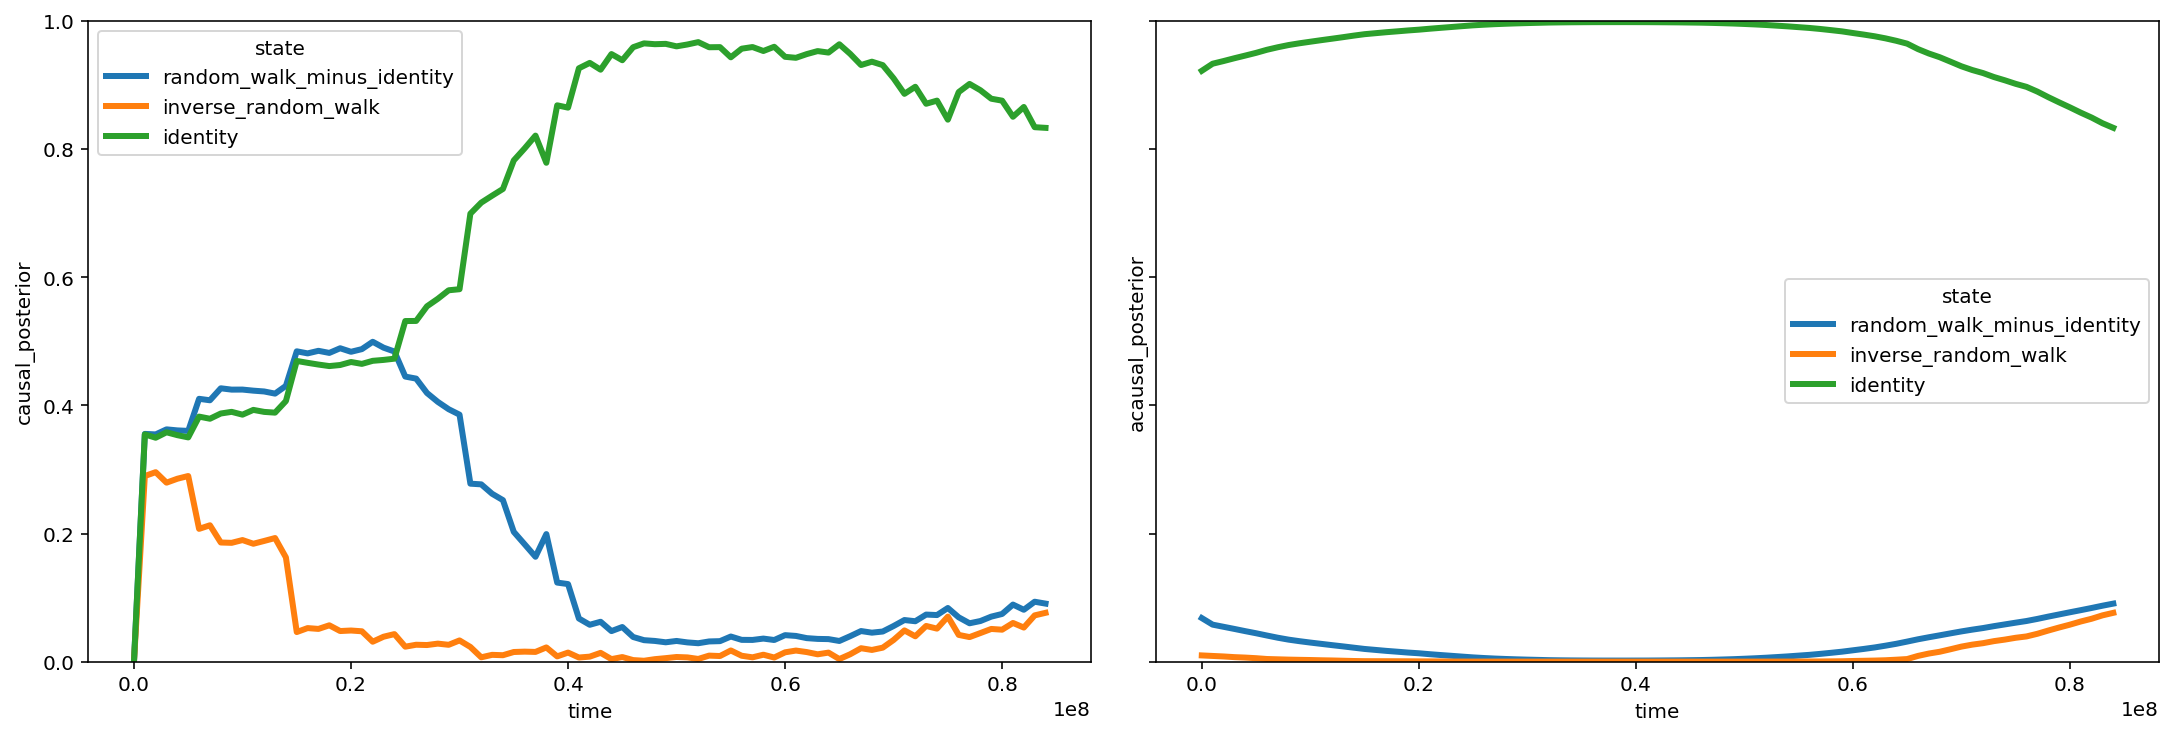

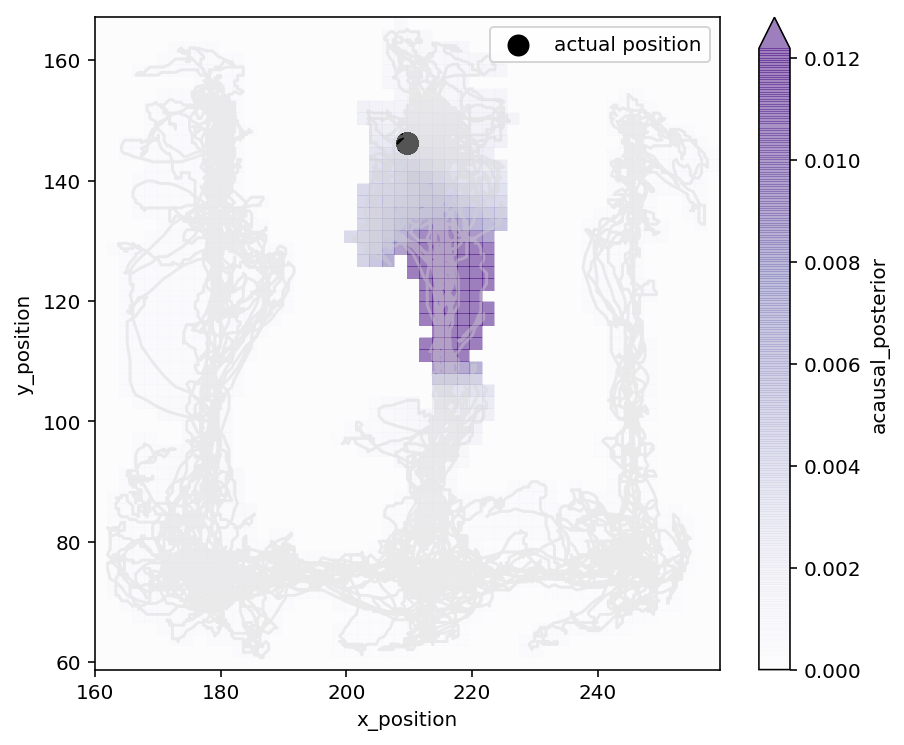

In [10]:
from src.visualization import (
    maximum_a_posteriori_estimate, plot_2D_position_with_color_time)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, sharey=True)
classifier.predict_proba(result).causal_posterior.plot(hue='state', ax=axes[0], linewidth=3)
classifier.predict_proba(result).acausal_posterior.plot(hue='state', ax=axes[1], linewidth=3);
axes[0].set_ylim((0, 1))


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

result.sum(['state', 'time']).acausal_posterior.plot(
    x='x_position', y='y_position', robust=True, cmap='Purples',
    alpha=0.5, vmin=0.0)

ax.plot(position.values[:, 0], position.values[:, 1], color='lightgrey', alpha=0.4, zorder=1)
ax.scatter(ripple_position.loc[ripple_number].values[:, 0],
           ripple_position.loc[ripple_number].values[:, 1], color='black', s=100,
           label='actual position');
ax.legend()

In [8]:
TRANSITION_TO_CATEGORY = {
    'identity': 'hover',
    'inverse_random_walk': 'fragmented',
    'random_walk_minus_identity': 'continuous',
}

results = []
for ripple_number in data['ripple_times'].index[:3]:
    time_slice = slice(*data['ripple_times'].loc[
        ripple_number, ['start_time', 'end_time']])
    m = data['multiunit'].sel(time=time_slice)
    results.append(classifier.predict(m, m.time - m.time[0]))
results = xr.concat(results, dim=data['ripple_times'].index[:3])
results = results.assign_coords(
    state=lambda ds: ds.state.to_index()
    .map(TRANSITION_TO_CATEGORY))

In [9]:
results

<xarray.Dataset>
Dimensions:            (ripple_number: 3, state: 3, time: 119, x_position: 50, y_position: 55)
Coordinates:
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.118000
  * x_position         (x_position) float64 161.0 163.0 165.0 ... 256.4 258.4
  * y_position         (y_position) float64 59.77 61.73 63.7 ... 164.2 166.1
  * state              (state) object 'continuous' 'fragmented' 'hover'
  * ripple_number      (ripple_number) int64 1 2 3
Data variables:
    likelihood         (ripple_number, time, state, x_position, y_position) float64 1.0 ... nan
    causal_posterior   (ripple_number, time, state, x_position, y_position) float64 0.0 ... nan
    acausal_posterior  (ripple_number, time, state, x_position, y_position) float64 0.0 ... nan

In [45]:
from loren_frank_data_processing import reshape_to_segments

spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(
    spikes, ripple_times,
    sampling_frequency=SAMPLING_FREQUENCY)

In [48]:
from src.analysis import (get_linear_position_order, get_place_field_max,
                          get_replay_info)

PROBABILITY_THRESHOLD = 0.8

ripple_position = reshape_to_segments(
    position, ripple_times, sampling_frequency=SAMPLING_FREQUENCY)
replay_info = get_replay_info(
    results, ripple_spikes, ripple_position, data['ripple_times'],
    SAMPLING_FREQUENCY, PROBABILITY_THRESHOLD)